# Given the stock information of at least the past 5 days of one particular company, try to predict the closing price of that company on a particular day

# Load libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load dataset and process date to ensure it is parseable

In [109]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", data.columns)
print(data.head())

# Convert 'Date' to datetime, handling errors
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Check for NaT values after conversion
if data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(data[data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2020-09-30  100.940002  1362200      A                       14.0   
1  2020-10-01  101.220001   723600      A                        0.0   
2  2020-10-02  100.010002   712200      A                        0.0   
3  2020-10-05  103.120003   803900      A                 

C:\Users\Admin\AppData\Local\Temp\ipykernel_22384\2789867827.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Retrieve the particular company and its closing price for past n days (n>=5)

In [110]:
# Define the company of interest
company = 'MMM'  # Replace with your company name

# Filter data for the specific company
company_data = data[data['Symbol'] == company]

# Check if the company data is empty
if company_data.empty:
    raise ValueError(f"No data found for company: {company}")

# Set the 'Date' column as the index
company_data.set_index('Date', inplace=True)

# Ensure we have at least 5 days of data
if len(company_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Use the last n days for modeling
last_n_days = company_data['Close'].tail(100)

# Ensure 'last_n_days' is not empty
if last_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

# Perform Rolling-window Cross Validation

In [111]:
# Define rolling window parameters
n = len(last_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows


# library ExponentialSmoothing can help us find optimal alpha, beta and gamma but it is up to us to input if trend and seasonal are addictive or multiplicative

In [112]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = last_n_days.iloc[:train_size + start]
    test = last_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  # Using squared=False for RMSE
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.543566
1   add      mul  1.524970
2   mul      add  1.400848
3   mul      mul  1.524759
Lowest RMSE: 1.4008479300742267
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Input the trend and seasonal that gives the lowest RMSE found using cross validation, unique to each company

In [113]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

# Forecast the next day's closing price
forecast = model.forecast(steps=1)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

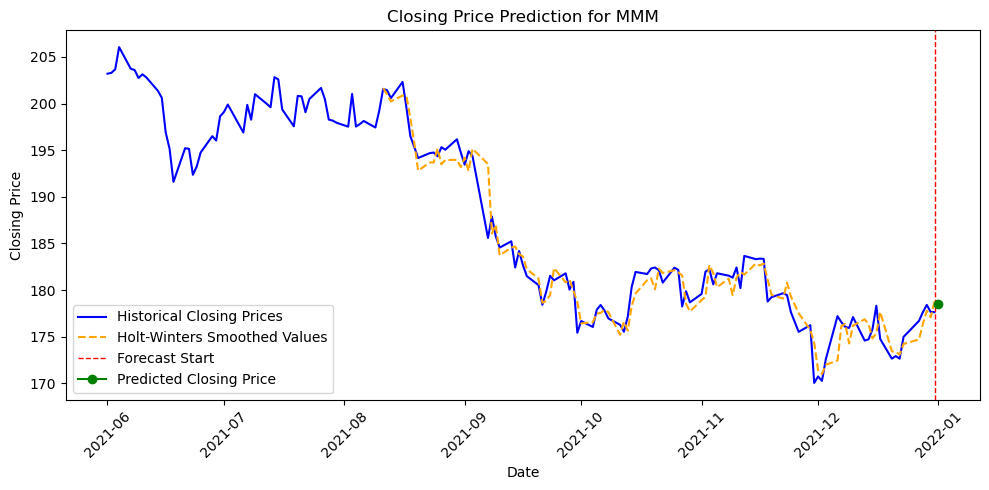

Predicted Closing Price for MMM on the next day: 178.45370983121967
Lowest RMSE: 1.4008479300742267


In [114]:
# Prepare data for visualization
historical_m_data = company_data['Close'][-150:]  # Last m days for context
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='red', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(historical_m_data.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label='Predicted Closing Price', color='green')
plt.title(f'Closing Price Prediction for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {company} on the next day: {forecast.iloc[0]}')
print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")

# Perform same operations on same company on TEST set

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2022-01-03  156.479996  1606300      A                        0.0   
1  2022-01-04  151.190002  2234000      A                        0.0   
2  2022-01-05  148.600006  2370500      A                        0.0   
3  2022-01-06  149.119995  2298300      A                 

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

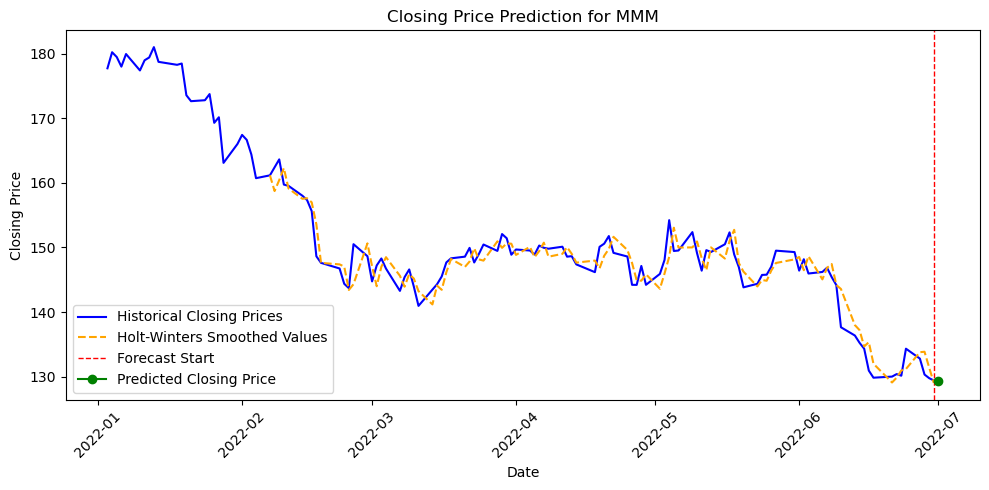

Predicted Closing Price for MMM on the next day: 129.26384814412614
Lowest RMSE: 1.4008479300742267


In [115]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", data.columns)
print(data.head())

# Convert 'Date' to datetime, handling errors
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Check for NaT values after conversion
if data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(data[data['Date'].isnull()])

# Define the company of interest
company = 'MMM'  # Replace with your company name

# Filter data for the specific company
company_data = data[data['Symbol'] == company]

# Check if the company data is empty
if company_data.empty:
    raise ValueError(f"No data found for company: {company}")

# Set the 'Date' column as the index
company_data.set_index('Date', inplace=True)

# Ensure we have at least 5 days of data
if len(company_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")


# Use the last n days for modeling
last_n_days = company_data['Close'].tail(100)

# Ensure 'last_n_days' is not empty
if last_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

# Fit the Holt-Winters model
model = ExponentialSmoothing(
    last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

# Forecast the next day's closing price
forecast = model.forecast(steps=1)

# Prepare data for visualization
historical_m_data = company_data['Close'][-150:]  # Last m days for context
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='red', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(historical_m_data.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label='Predicted Closing Price', color='green')
plt.title(f'Closing Price Prediction for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {company} on the next day: {forecast.iloc[0]}')
print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


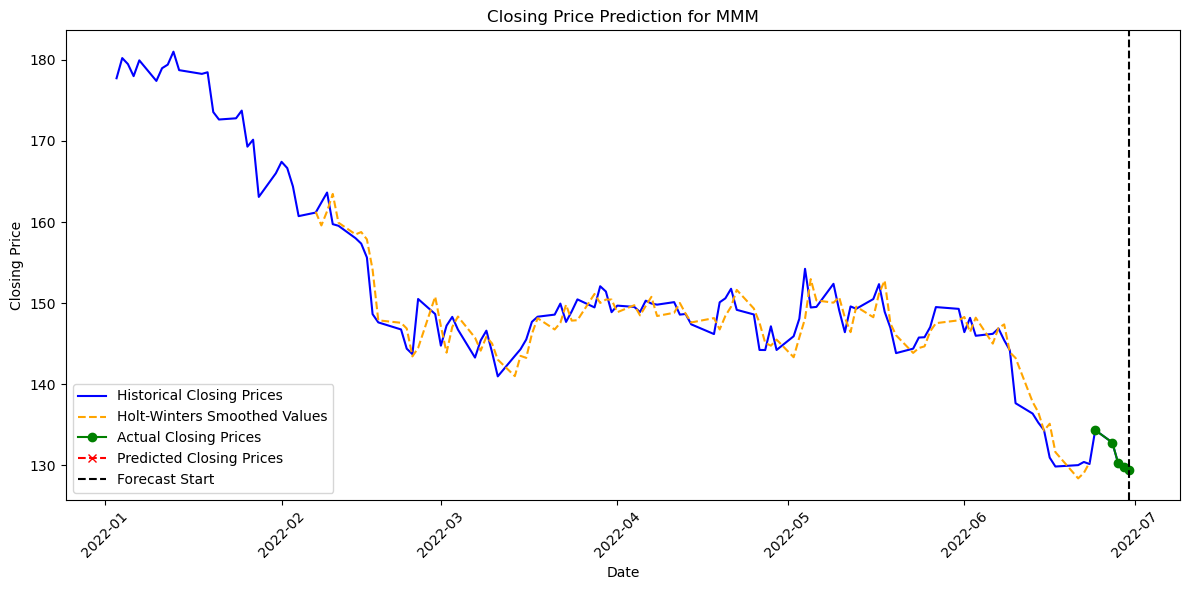

RMSE between actual and predicted values: 0.4192147168589031


In [116]:
# Fit the model on the data excluding the last n_forecast_days
# Define the number of days to forecast
n_forecast_days = 5  # Example: Forecast for the next 5 days

# Use the last n_forecast_days from the actual data for comparison
actual_values = company_data['Close'].tail(n_forecast_days)

# Fit the model on the data excluding the last n_forecast_days
train_data = last_n_days[:-n_forecast_days]

model = ExponentialSmoothing(
    train_data,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7
).fit()

# Get the smoothed values for the training data
smoothed_values = model.fittedvalues

# Forecast the next n_forecast_days closing prices
forecast = model.forecast(steps=n_forecast_days)

# Ensure the forecast and actual values align for RMSE calculation
actual_values = company_data['Close'].tail(n_forecast_days)

# Create a DataFrame for plotting
forecast_index = pd.date_range(start=actual_values.index[-1] + pd.DateOffset(days=1), periods=n_forecast_days)
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
actual_df = pd.DataFrame({'Actual': actual_values})
smoothed_df = pd.DataFrame({'Smoothed': smoothed_values})

# Combine actual, smoothed, and forecasted data for plotting
combined_df = pd.concat([actual_df, forecast_df], axis=1)
smoothed_index = smoothed_values.index

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(company_data.index, company_data['Close'], label='Historical Closing Prices', color='blue')
plt.plot(smoothed_index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.plot(combined_df.index, combined_df['Actual'], marker='o', label='Actual Closing Prices', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], marker='x', linestyle='--', label='Predicted Closing Prices', color='red')
plt.axvline(x=actual_values.index[-1], color='black', linestyle='--', label='Forecast Start')
plt.title(f'Closing Price Prediction for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the RMSE
print(f'RMSE between actual and predicted values: {rmse}')
